### Dooh AR Senior D - AI Team - Barnatt Wu and Johnathan Vu
#### The following notebook is used to experiment with the yolov7-tiny model to make it compatible with our data and Snap's Lens Studio

Download data
Some links:
https://docs.ultralytics.com/guides/hyperparameter-tuning/


In [ ]:
import urllib.request, os

# download the model's weights 
# NOTE: the model is not compatible with the ultralytics library

os.makedirs("./models/yolov7_tiny/weights", exist_ok=True)
url = "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"
save_path = "./models/yolov7_tiny/weights/yolov7-tiny.pt"

urllib.request.urlretrieve(url, save_path)
print("Downloaded:", save_path)

In [1]:
from ultralytics import YOLO

# import and intialize yolo model weights (.pt)
# model = YOLO("yolov8n.pt")
model = YOLO("./models/yolov8/yolov8n.pt")

In [ ]:
# exmaple usage of the model
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained model

# Run inference on an image
results = model("test_images/test_wtc.JPG", imgsz=640)

# Show results inline
for r in results:
    im_array = r.plot()  # render detections
    im = Image.fromarray(im_array)
    plt.imshow(im)
    plt.axis("off")
    plt.show()

url = "https://ultralytics.com/images/zidane.jpg"
results = model(url, imgsz=640)

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array)
    plt.imshow(im)
    plt.axis("off")
    plt.show()

### Fine Tuning YOLO on WTC dataset

In [3]:
from dotenv import load_dotenv
from roboflow import Roboflow
import os

load_dotenv()

roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=roboflow_api_key)
# rf_project_name = "dooh-ar-senior-d-ud86j"
version = 1
rf_project_name = "hudson-yards-the-edge-h7udo"
project = rf.workspace().project(rf_project_name)
dataset = project.version(version).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hudson-yards-the-Edge-1 in yolov8:: 100%|██████████| 2588/2588 [00:01<00:00, 1728.97it/s]


In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))


CUDA available: True
Device count: 1
0 NVIDIA GeForce RTX 5060 Laptop GPU


In [6]:
# Fine-tune YOLOv8 model on your WTC dataset
from ultralytics import YOLO
import os

project_root = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()

relative_path = r"datasets/hudson-yards-the-Edge-1/data.yaml"
data_yaml_path = os.path.join(project_root, relative_path)

# Load pre-trained model
model = YOLO("yolov8n.pt")


# Train the model on your dataset
results = model.train(
    data=data_yaml_path,
    device = 0,
    epochs=25,
    batch=16,
    workers=1,
    amp=True,
    lr0=0.01,
    exist_ok=True,
    plots=True,
    val=True,
)

print("Training completed!")
print(f"Results saved to: {results.save_dir}")


Ultralytics 8.3.227  Python-3.12.12 torch-2.10.0.dev20251102+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\barna\Downloads\Dooh AR Senior D\dooh_ai\datasets/hudson-yards-the-Edge-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, opt

In [7]:
import os, shutil
from ultralytics import YOLO

project_root = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()

# fp16 export
fp16_path = model.export(
    format="onnx",
    device=0,
    half=True,
    simplify=True,
    dynamic=False,
    project="./models/yolov8n/fp16",
    name="yolov8n_edge_finetuned_fp16",
)

# Create destination and move file
dst_fp16 = os.path.join(project_root, "models", "custom", "fp16")
os.makedirs(dst_fp16, exist_ok=True)
shutil.move(fp16_path, os.path.join(dst_fp16, "edge_finetuned_16.onnx"))

# fp32 export
fp32_path = model.export(
    format="onnx",
    simplify=True,
    dynamic=False,
    project="./models/yolov5/fp32",
    name="yolov8n_edge_finetuned",
)

dst_fp32 = os.path.join(project_root, "models", "custom", "fp32")
os.makedirs(dst_fp32, exist_ok=True)
shutil.move(fp32_path, os.path.join(dst_fp32, "edge_finetuned_32.onnx"))

print("Both FP16 and FP32 models exported and moved successfully!")


Ultralytics 8.3.227  Python-3.12.12 torch-2.10.0.dev20251102+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'C:\Users\barna\Downloads\Dooh AR Senior D\dooh_ai\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: C:\Users\barna\.conda\envs\AI
Resolved 15 packages in 1.02s
Prepared 2 packages in 25.68s
Installed 2 packages in 1.12s
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74

requirements: AutoUpdate success  28.9s
WARNING requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export wi

WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading ./models/custom/fp32/edge_finetuned_32.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})

image 1/1 c:\Users\barna\Downloads\Dooh AR Senior D\dooh_ai\test_edge.jpg: 640x640 1 Hudson yards edge, 140.8ms
Speed: 4.3ms preprocess, 140.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


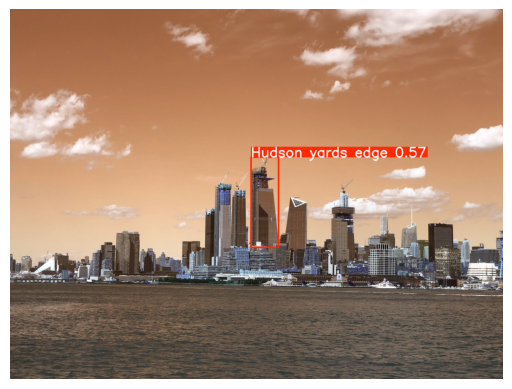

In [12]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Test inference on trained weights

# testing_model = YOLO("./models/custom/fp16/wtc_finetuned_16.onnx")
testing_model = YOLO("../runs/detect/train/weights/best.pt")
results = testing_model("./test_images/test_inference.webp", half=True, task="segment")
for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array)
    plt.imshow(im)
    plt.axis("off")
    plt.show()

Using matplotlib backend: module://matplotlib_inline.backend_inline
Found 16 detections above 0.01
After NMS: 1 detections


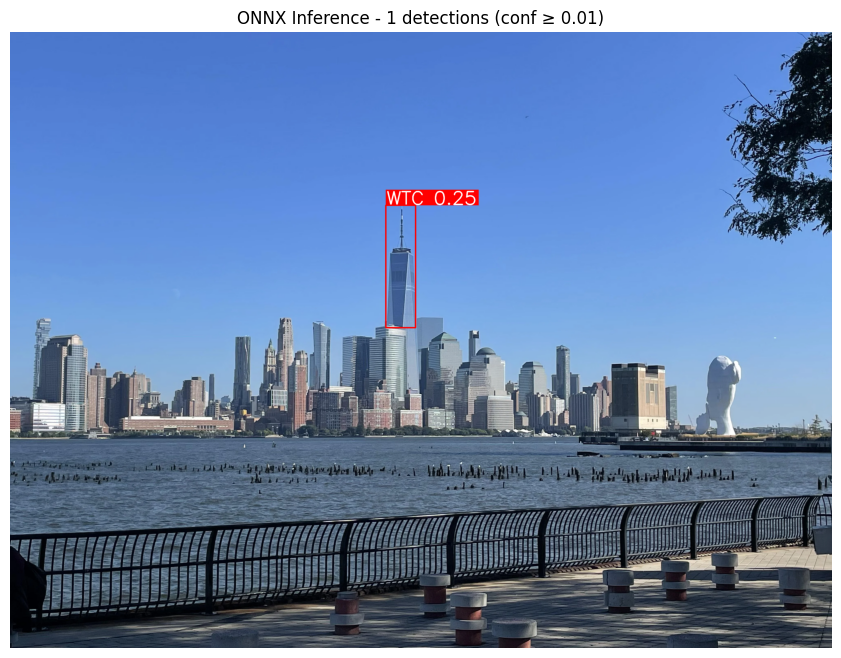

In [3]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib

# load onnx model
sess = ort.InferenceSession(
    "./models/custom/fp32/wtc_finetuned_32.onnx",
    providers=["CUDAExecutionProvider"]
)
input_name = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

# load test image
path = "./test_images/test_inference.webp"
orig = cv2.imread(path)
rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
h0, w0 = rgb.shape[:2]

# letterboxing
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    shape = img.shape[:2]
    ratio = min(new_shape[0]/shape[0], new_shape[1]/shape[1])
    new_unpad = (int(round(shape[1]*ratio)), int(round(shape[0]*ratio)))
    dw, dh = new_shape[1]-new_unpad[0], new_shape[0]-new_unpad[1]
    dw, dh = dw/2, dh/2
    img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh-0.1)), int(round(dh+0.1))
    left, right = int(round(dw-0.1)), int(round(dw+0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                             cv2.BORDER_CONSTANT, value=color)
    return img, ratio, (dw, dh)

img, ratio, dwdh = letterbox(rgb, (640, 640))
img_input = np.ascontiguousarray(img.transpose(2, 0, 1)[None], dtype=np.float32) / 255.0

# run inference
outputs = sess.run(output_names, {input_name: img_input})
pred, proto = outputs

# parse segmentation results
pred = np.squeeze(pred)
proto = np.squeeze(proto)

boxes = pred[:4, :].T
obj = pred[4:5, :].T
cls_sc = pred[5:6, :].T
mask_coeffs = pred[6:, :].T

scores = (obj * cls_sc).flatten()

# adjust confidence threshold here
conf_thres = 0.01
mask = scores > conf_thres
boxes, scores, mask_coeffs = boxes[mask], scores[mask], mask_coeffs[mask]

print(f"Found {len(boxes)} detections above {conf_thres}")

# Apply simple non-maximum suppression
def nms(boxes, scores, iou_threshold=0.45):
    if len(boxes) <= 1:
        return boxes, scores

    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    boxes_xyxy = np.column_stack([x1, y1, x2, y2])

    indices = np.argsort(scores)[::-1]
    keep = []

    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        if len(indices) == 1:
            break

        current_box = boxes_xyxy[current]
        others = boxes_xyxy[indices[1:]]

        x1_int = np.maximum(current_box[0], others[:, 0])
        y1_int = np.maximum(current_box[1], others[:, 1])
        x2_int = np.minimum(current_box[2], others[:, 2])
        y2_int = np.minimum(current_box[3], others[:, 3])
        inter = np.maximum(0, x2_int - x1_int) * np.maximum(0, y2_int - y1_int)

        area_c = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
        area_o = (others[:, 2] - others[:, 0]) * (others[:, 3] - others[:, 1])
        union = area_c + area_o - inter
        iou = inter / np.maximum(union, 1e-6)

        indices = indices[1:][iou <= iou_threshold]

    return boxes[keep], scores[keep]

boxes, scores = nms(boxes, scores)
print(f"After NMS: {len(boxes)} detections")

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

obj = sigmoid(pred[4:5, :].T)
cls_sc = sigmoid(pred[5:6, :].T)
mask_coeffs = pred[6:, :].T
scores = (obj * cls_sc).flatten()

# rescale boxes back to original image
def scale_boxes(boxes, ratio, dwdh, orig_shape):
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2

    x1 = (x1 - dwdh[0]) / ratio
    y1 = (y1 - dwdh[1]) / ratio
    x2 = (x2 - dwdh[0]) / ratio
    y2 = (y2 - dwdh[1]) / ratio

    x1 = np.clip(x1, 0, orig_shape[1])
    y1 = np.clip(y1, 0, orig_shape[0])
    x2 = np.clip(x2, 0, orig_shape[1])
    y2 = np.clip(y2, 0, orig_shape[0])

    return np.column_stack([x1, y1, x2, y2])

boxes = scale_boxes(boxes.copy(), ratio, dwdh, (h0, w0))
scores = scores.flatten()

# draw the overlay
overlay = rgb.copy()
font_scale = 3
font_thickness = 6
box_thickness = 5

for i, (box, sc) in enumerate(zip(boxes, scores)):
    x1, y1, x2, y2 = box.astype(int)
    label = f"WTC {float(sc):.2f}"
    color = (255, 0, 0)

    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(overlay, (x1, max(y1 - th - 10, 0)), (x1 + tw + 8, y1), color, -1)
    cv2.putText(overlay, label, (x1 + 4, max(y1 - 4, 0)),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)
    cv2.rectangle(overlay, (x1, y1), (x2, y2), color, box_thickness)

# djsplay
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"ONNX Inference - {len(boxes)} detections (conf ≥ {conf_thres})")
plt.show()
